<center><font size="+4">Programming & Data Analytics & AI 2 PM 2024/2025</font></center>
<center><font size="+2">Sant'Anna School of Advanced Studies, Pisa, Italy</font></center>
<center><img src="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/jupyter/jupyterNotebooks/images/sssaLEMBEDSdtu.png" width="900" alt="L'EMbeDS"></center>

<center><font size="+2">Course responsible</font></center>
<center><font size="+2">Andrea Vandin a.vandin@santannapisa.it</font></center>

---

<center><font size="+2">Notebook for Class 8 </font></center>
<center><font size="+2"> Conformance Checking. Data lab
</font></center>

---
---

In [2]:
url_github_repo="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/"

pm_slides=url_github_repo+'jupyter/jupyterNotebooks/images/PM/'
from IPython.display import Image, display

For an informed discussion on this topic, I recommend you watching classes of Module 3 of the [Coursera course on PM](https://www.coursera.org/learn/process-mining/home/welcome)
- https://www.coursera.org/learn/process-mining/home/module/3



> Below we provide screenshots from some slides used above

# Overview

Often, one wants to compare an event log with
- A reference (or normative) model
- A mined model

This is done to
- understand whether the expected behavior actually occurs
- identify and analyze deviations
  - These _outliers_ are often the  _interesting cases_
    - some may be good (doctors deviate to save the life of a specific patient)
    - some may be bad (an office forgets performing a quality  check before sending money out)
- compare the quality of different process discovery algorithms

During the classes on pm4py we studied two approaches to conformance checking
- token-based 
  - tells us how much each trace and all logs conform to a model (it counts missing and remaining tokens)
- alignment-based
  1. tells us how much each trace and all logs conform to a model
  2. tells us how to modify the model or traces to make the model conformant


We know that the quality of a model (or of a model discovery technique) can be measured using 4 dimensions
- However, in conformance checking, __replay fitness__ is the most important
  - How well can my model replicate the logs? 

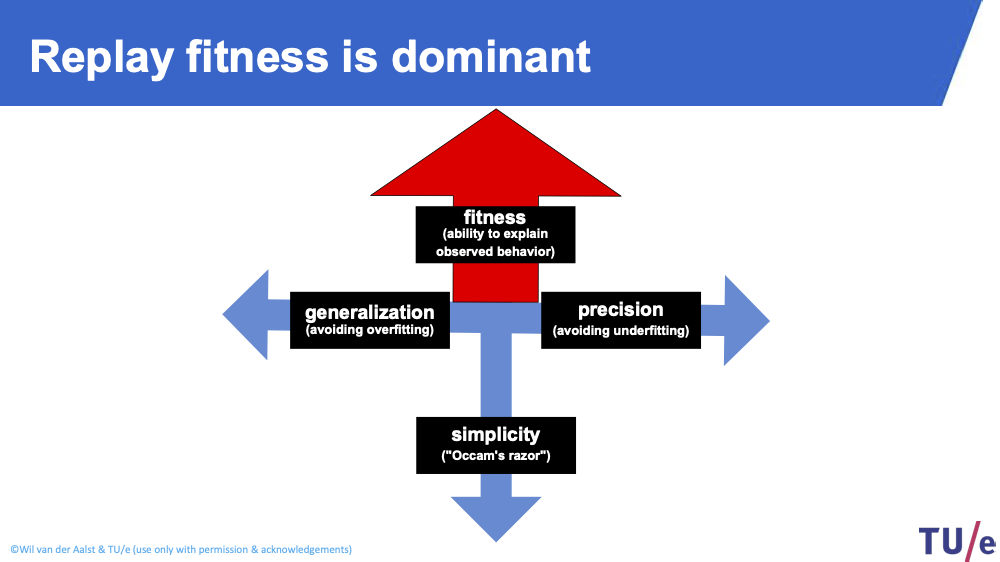

In [4]:
img=Image(pm_slides+'confFitness.png',width=700)
display(img)

Recap on precision and fitness:
- Precision: Ability to produce only traces appearing in the event log
  - Maybe not all traces in the log are covered, but the model shall not create spurious traces
- Fitness: Ability to replay the observed behavior
  - It shall cover all traces in the event log, we don't care about additional spurious traces

When doing conformance checking we can
- Give a global conformance measure
- Give diagnostics information on problems in the __log__ and on how to fix it
- Give diagnostics information on problems in the __model__ and on how to fix it

Not all conformance checking techniques provide these information

# Conformance checking based on Causal footprints

By now, you should know very well the notion of 
- Footprint of an event log

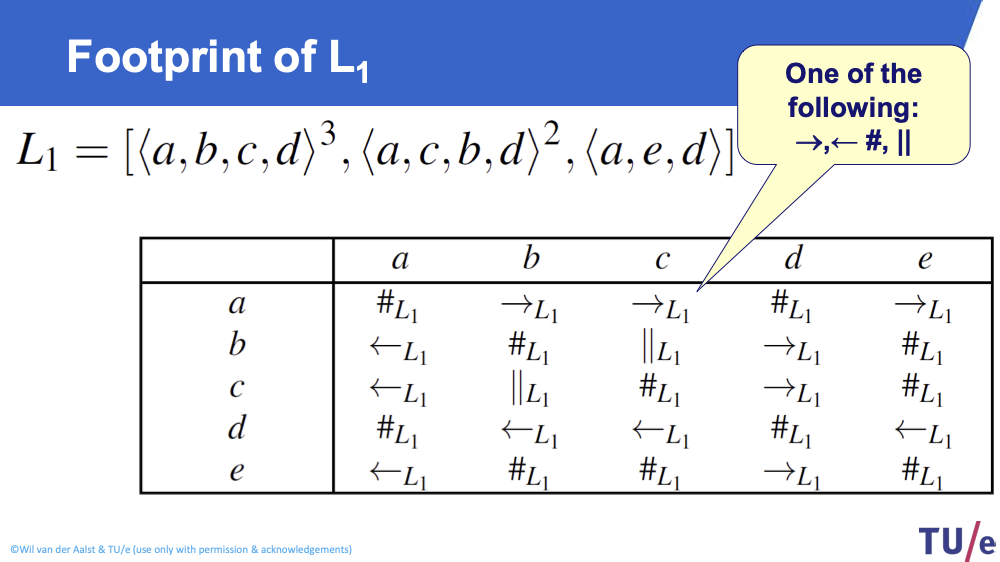

In [6]:
display(Image(pm_slides+'footprint.png',width=700))

The Alpha miner is based on this:
- __Direct succession `>`__
  - `a>b`: There is at least one trace where `b` is the next event after `a`
- __Sequence `->`__ (also __Causality__)
  - `a->b`: `a>b` __and not__ `b>a`
- __Parallel `||`__
  - `a||b`: `a>b` __and__ `b>a`
- __Choice `#`__
  - `a#b`: __not__ `a>b` __and not__ `b>a`

E.g.,
- `a -> b` means that `a` is followed by `b` at least once. While `b` is never followed by `a`
- `c || b` means that `c` is followed by `b` at least once, and vice versa
- `a # d` means that `a` is never  by `d`, and vice versa

You may recall that the __alpha miner guarantees__ that:
- the footprint of the source log
- the footprint of all logs generable by a model

__have the same footprint__

That is, the alpha miner is perfect in finding and modeling these _local dependencies_

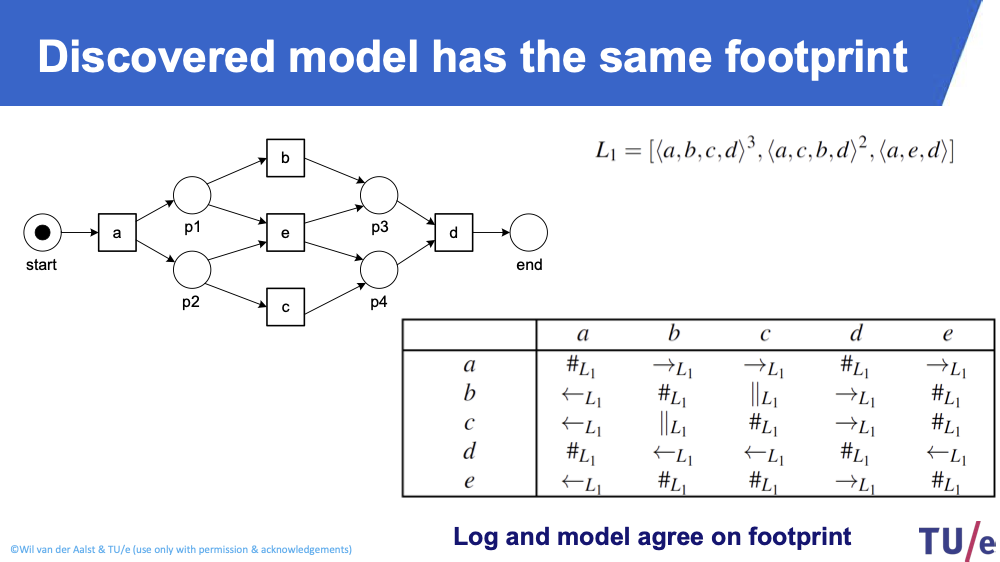

In [8]:
display(Image(pm_slides+'sameFootprint.png',width=700))

Conformance checking based on Causal footprints
- just compares the footrpint of a log and of a model
- we compute the fraction of cells coinciding:
  - 1: perfect match
  - 0: worst match possible  

# Conformance checking based on Token-based replay 

# Conformance checking based on Alignment